This example quantifies the effect of back-reaction.

In [21]:
#Annihilation or decay?
inj_type = 'decay'

#Annihilate/Decay into
inj_particle = 'photon'

#Useful definitions
if inj_particle == 'electron':
    inj_str = 'elec'
    mass = phys.me
else:
    inj_str = 'phot'
    mass = 0

# Import Modules

In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

from pathlib import Path

In [43]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

np.set_printoptions(threshold=np.nan)

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

## Load Transfer Functions

In [5]:
%autoreload

direc = cwd+'/../../tfs/photons/'
direc_arr = [direc, direc]
CMB_subtracted=True
xes = np.array([
    0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.8, -1.4, -1, -.8, -0.65, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4]),
    None]
)
string_arr = ['_xHe0', '_standard_xe_xHe_full_rs']
switching_rs = 1600

(highengphot_tf_interp,
     lowengphot_tf_interp,
     lowengelec_tf_interp,
     highengdep_interp,
     CMB_engloss_interp
    ) = main.load_trans_funcs(direc_arr, string_arr, xes, CMB_subtracted=CMB_subtracted)

highengphot_tf_interp.rs_nodes[0] = switching_rs
lowengphot_tf_interp.rs_nodes[0]  = switching_rs
lowengelec_tf_interp.rs_nodes[0]  = switching_rs
highengdep_interp.rs_nodes[0]     = switching_rs
CMB_engloss_interp.rs_nodes[0]    = switching_rs
    
# Useful Definitions
photeng = highengphot_tf_interp.eng
eleceng = lowengelec_tf_interp.eng

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Subtracting CMB component from lowengphot
Finished CMB subtraction
Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
noninterp
noninterp
Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Subtracting CMB component from lowengphot
Finished CMB subtraction
Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
noninterp
noninterp
Done.



### ics transfer functions

In [6]:
%autoreload
direc = cwd+'/../../tfs/ics/'
ics_file = Path(direc+'ics_thomson_ref_tf.p')

if ics_file.is_file():
    ics_thomson_ref_tf = pickle.load(open(direc+'ics_thomson_ref_tf.p', "rb"))
    ics_rel_ref_tf = pickle.load(open(direc+'ics_rel_ref_tf.p', "rb"))
    engloss_ref_tf = pickle.load(open(direc+'engloss_ref_tf.p', "rb"))
else:
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()
    pickle.dump(ics_thomson_ref_tf, open(direc+'ics_thomson_ref_tf.p', "wb"))
    pickle.dump(ics_rel_ref_tf, open(direc+'ics_rel_ref_tf.p', "wb"))
    pickle.dump(engloss_ref_tf, open(direc+'engloss_ref_tf.p', "wb"))

### Download xe_idl

In [25]:
direc = cwd+'/../../ih_continuous_'+inj_str

hdul = fits.open(
    direc+'/IDL_runs/'
    +'tf_z_3.000E+03_nstep_6398_logE_1.067E+01_xe_0.000E+00.fits'
)
    
data = hdul[1].data

idl_redshift = data.field('redshift')[0]
xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

# Load Max $\langle \sigma v \rangle$ and $\tau$

In [7]:
user = 'gridgway'
f_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_electron_extended.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1] 

f_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_photon.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1] 

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def max_xsec_elec_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))
    elif injection_type == 'decay':
        return decay_elec_CMB(mDM*1e-9)

def max_xsec_phot_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))
    elif injection_type == 'decay':
        return decay_phot_CMB(mDM*1e-9)

# Calculate With and Without back-reaction

In [20]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = np.log10(highengphot_tf_interp.eng[-1])*.99
log10eng = log10eng[2:]

In [31]:
%autoreload

def struct_boost(rs):
    return 1

def get_column(i, diff_list, inj_particle, inj_type, end_rs=4.995):
    """ inj_type = 'swave' has not been worked out yet
    """
    #injection energy, DM mass, center-of-mass energy
    Einj = 10**log10eng[i]
    mDM = 2*Einj + 2*mass
    Ecom=mDM
    
    # OR EINJ -> mDM???
    sigmav = max_xsec_phot_CMB(Einj, 'swave')
    tau = max_xsec_phot_CMB(Einj, 'decay')
    
    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)
    
    if inj_type == 'swave':
        mDM = mDM/2
        Ecom = 2*mDM   
    
    if inj_particle == 'electron':
        Etmp = eleceng[eleceng < Einj][-1]
        elec_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            eleceng
        )
        elec_spec_init.rs = 3000
        elec_spec_init.switch_spec_type()
        
        phot_spec_init = Spectrum(photeng,
                                 np.zeros_like(photeng),
                                 spec_type='N',
                                 rs=3000)
    else:
        Etmp = photeng[photeng < Einj][-1]
        phot_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            photeng
        )
        phot_spec_init.rs = 3000
        phot_spec_init.switch_spec_type()
        
        elec_spec_init = Spectrum(eleceng,
                                 np.zeros_like(eleceng),
                                 spec_type='N',
                                 rs=3000)
        
    a = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_N, rate_func_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=1, std_soln=True,
        reion_switch=False,
        struct_boost=None,
        ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
        xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
        use_tqdm=True
    )
    
    b = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_N, rate_func_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=1, std_soln=False,
        reion_switch=False,
        struct_boost=None,
        ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
        xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
        use_tqdm=True
    )

    diff_list[i] = (1-b[1]/a[1]) * 100

In [35]:
%autoreload
diff_list = [None for i in np.arange(len(log10eng))]

for k in tqdm(np.arange(len(log10eng))):
    get_column(k, diff_list, inj_particle, inj_type, end_rs=4.995)

# pickle.dump(diff_list, open('/Users/gridgway/Desktop/backReact_'+inj_str+'_residuals.p', "wb"))
pickle.dump(diff_list, open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals_2019_01_23.p', "rb"))

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/gridgway/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/gridgway/anaconda3/lib/python3.6/site-packages/tqdm-4.19.5-py3.6.egg/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/gridgway/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



../darkhistory/history/tla.py:212: RuntimeWarning: overflow encountered in cosh
  return 2 * np.cosh(yHII)**2 * -phys.dtdz(rs) * (
../darkhistory/history/tla.py:185: RuntimeWarning: overflow encountered in cosh
  + dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
../darkhistory/history/tla.py:185: RuntimeWarning: invalid value encountered in double_scalars
  + dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
/Users/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
../darkhistory/history/tla.py:212: RuntimeWarning: overflow encountered in double_scalars
  return 2 * np.cosh(yHII)**2 * -phys.dtdz(rs) * (
../darkhistory/history/tla.py:185: RuntimeWarning: overflow encountered in double_scalars
  + dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
../darkhistory/history/tla.py:191: RuntimeWarning: invali

In [63]:
pickle.dump(diff_list, open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals_2019_01_23.p', "wb"))

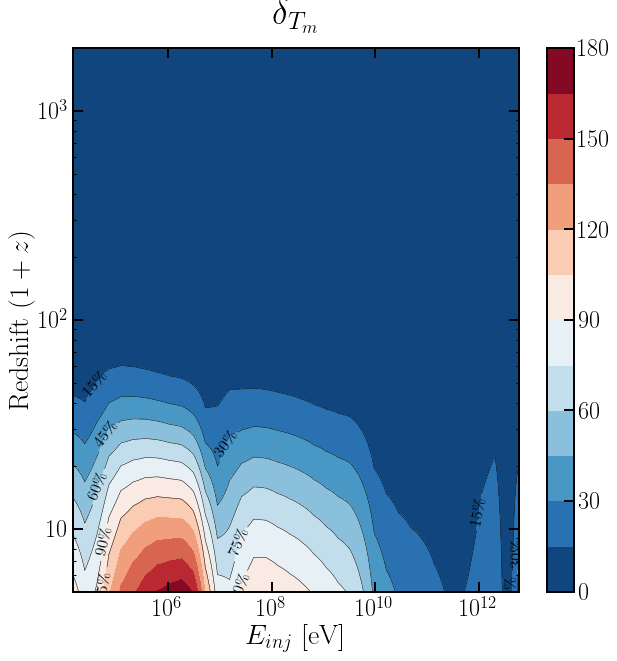

In [61]:
user = 'gridgway'

# diff_list = pickle.load(open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/backReact_phot_residuals.p', "rb"))
diff_list = pickle.load(open('/Users/'+user+'/Desktop/backReact_phot_residuals.p', "rb"))

# rs_list = np.exp(np.arange(np.log(3000), np.log(5), step=-0.002))
rs_list = np.exp(np.arange(np.log(3000), np.log(4.996), step=-0.001))

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')
log10eng = fz_phot_decay[0:2800:70, 0]
log10eng = log10eng[2:]


plt.figure()

ax = plt.gca()
ax.loglog()

plt_heating = plt.contour(
    10**log10eng, rs_list, 
    np.transpose(np.abs(diff_list)),
    levels=[15, 30, 45, 60, 75, 90, 105],
    linewidths=0.5,
    colors='k'
)

plt.axis([10**log10eng[0], 10**log10eng[-1], 5, 2e3])

labels = { 
    15:r'$15$\%', 
    30:r'$30$\%',
    45:r'$45$\%',
    60:r'$60$\%',
    75:r'$75$\%',
    90:r'$90$\%',
    105:r'$105$\%'
}

plt.clabel(
    plt_heating, inline=True, fontsize=16, rightside_up=True,
    fmt=labels
)

cntr1 = ax.contourf(10**log10eng, rs_list, np.transpose(np.abs(diff_list)), 14, cmap="RdBu_r")
plt.colorbar(cntr1, ax=ax)

plt.title(r'\bf{$\delta_{T_m}$}')
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'$E_{inj}$ [eV]')

user='gridgway'
# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/backReact_phot_residuals.pdf')
plt.savefig('/Users/'+user+'/Desktop/backReact_phot_residuals.png')

[5, 2000.0, 1, 10000.0]

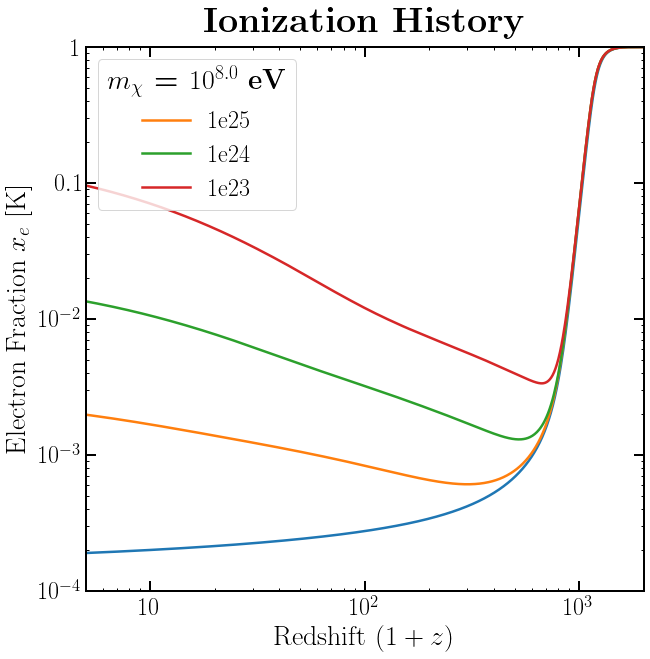

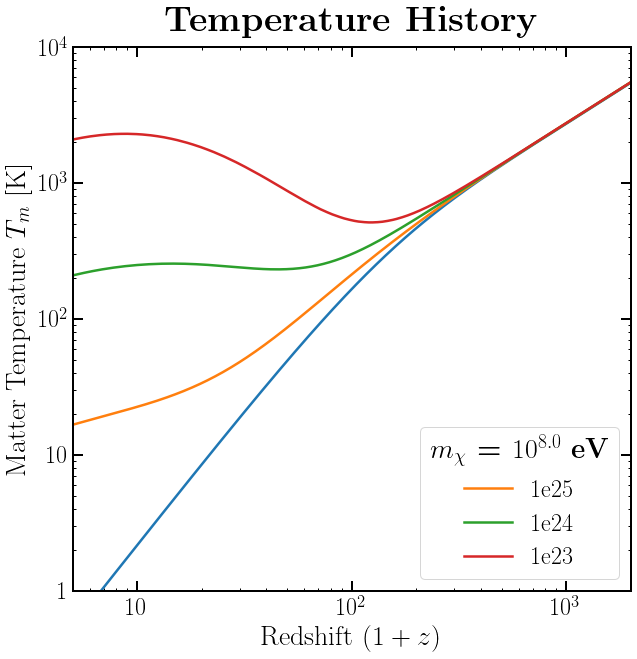

In [121]:
plt.figure()
plt_0, = plt.plot(soln[0,:], soln[2,:], label='None')
plt_3, = plt.plot(b3[3].rs, b3[0], label='1e25')
plt_2, = plt.plot(b2[3].rs, b2[0], label='1e24')
plt_1, = plt.plot(b1[3].rs, b1[0], label='1e23')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_3, plt_2, plt_1],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 1])
#plt.savefig('/home/gridgway/Desktop/xe_decay_comparison.png')

plt.figure()
plt_T0, = plt.plot(soln[0,:], soln[1,:]/phys.kB, label='None')
plt_T3, = plt.plot(b3[3].rs, b3[1]/phys.kB, label='1e25')
plt_T2, = plt.plot(b2[3].rs, b2[1]/phys.kB, label='1e24')
plt_T1, = plt.plot(b1[3].rs, b1[1]/phys.kB, label='1e23')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_T3, plt_T2, plt_T1],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=4
                 )
plt.setp(leg2.get_title(),fontsize=28)
plt.axis([5, 2e3, 1, 1e4])
#plt.savefig('/home/gridgway/Desktop/Tm_decay_comparison.png')

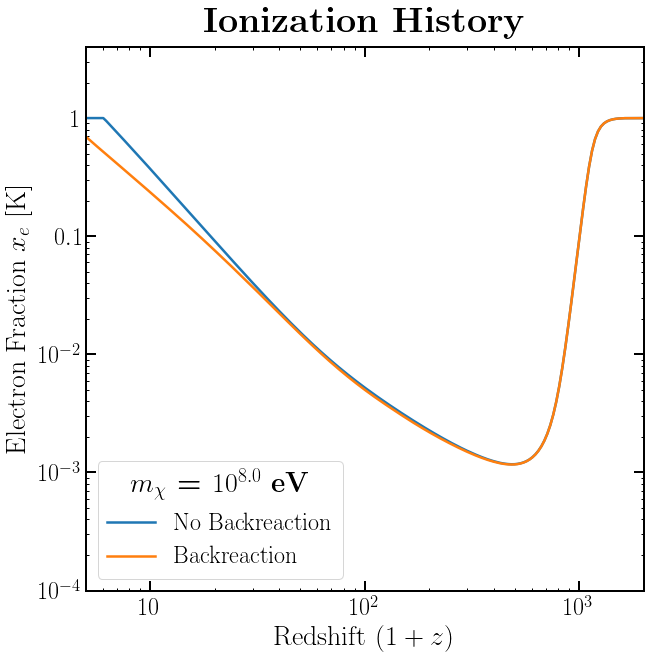

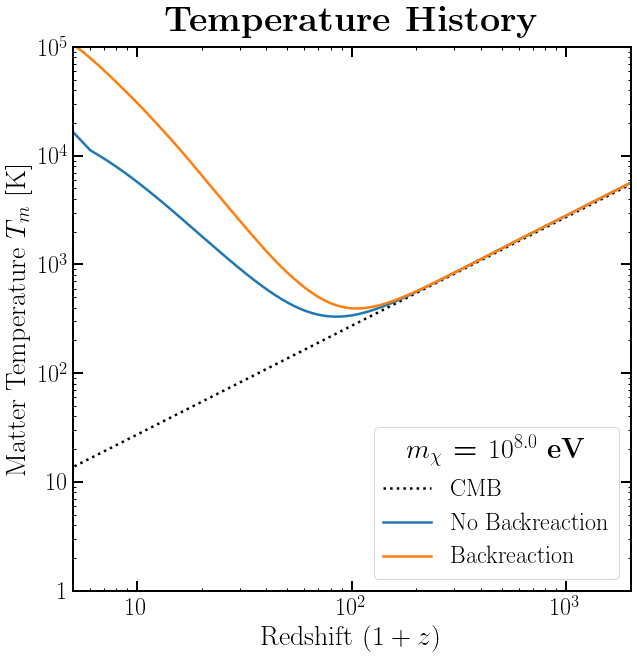

In [144]:
plt.figure()
plt_xe_std, = plt.plot(a[3].rs, a[0], label='No Backreaction')
plt_xe_backReact, = plt.plot(b[3].rs, b[0], label='Backreaction')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_xe_std, plt_xe_backReact],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=3
                )
plt.setp(leg.get_title(),fontsize=28)
plt.axis([5, 2e3, 1e-4, 4])
plt.savefig('/home/gridgway/Desktop/xe_elec.png')

plt.figure()
plt_TCMB, = plt.plot(a[3].rs, phys.TCMB(a[3].rs)/phys.kB, 'k:', label='CMB')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='No Backreaction')
plt_Tm_backReact, = plt.plot(b[3].rs, b[1]/phys.kB, label='Backreaction')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_TCMB, plt_Tm_std, plt_Tm_backReact],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=4
                 )
plt.setp(leg2.get_title(),fontsize=28)
plt.axis([5, 2e3, 1, 1e5])
plt.savefig('/home/gridgway/Desktop/Tm_elec.png')

## Generate $f_c(z)$ contour plots

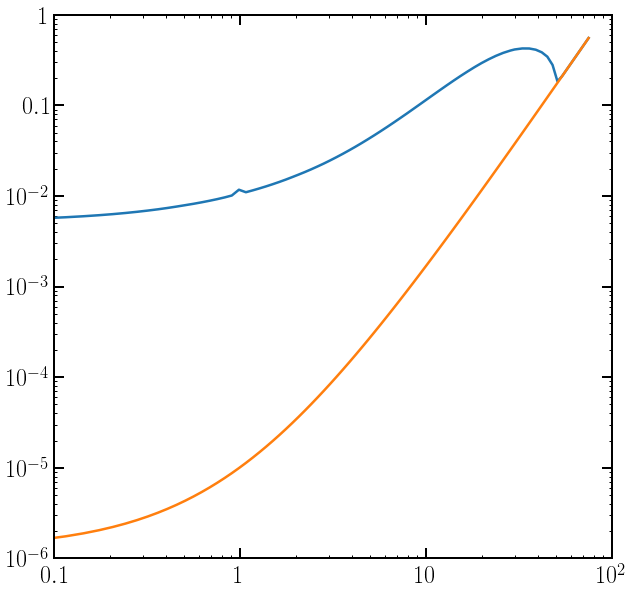

In [151]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(struct_data[:,0]-1, [np.sqrt(struct_boost(rs))*phys.rho_DM*rs**3*1e-9 for rs in struct_data[:,0]])
plt.plot(struct_data[:,0]-1, [phys.rho_DM*rs**3*1e-9 for rs in struct_data[:,0]])
plt.axis([1e-1, 1e2, 1e-6, 1])
plt.show()

# Heating Processes

In [40]:
def compton_cooling_rate(xe, T_matter, rs):
    """Returns the Compton cooling rate. 

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    T_matter : float
        The matter temperature in eV. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Compton cooling rate in eV/s. 
    """
    return (
        xe / (1 + xe + phys.nHe/phys.nH) * (phys.TCMB(rs) - T_matter)
        * 32 * phys.thomson_xsec * phys.stefboltz
        * phys.TCMB(rs)**4 / (3 * phys.me)
    )

# Ionization Processes

In [41]:
def alpha_recomb(T_matter):
    """Case-B recombination coefficient. 

    Parameters
    ----------
    T_matter : float
        The matter temperature. 

    Returns
    -------
    float
        Case-B recombination coefficient in cm^3/s. 
    """ 
    
    # Fudge factor recommended in 1011.3758
    fudge_fac = 1.126

    return (
        fudge_fac * 1e-13 * 4.309 * (1.16405*T_matter)**(-0.6166)
        / (1 + 0.6703 * (1.16405*T_matter)**0.5300)
    )

def beta_ion(T_rad):
    """Case-B photoionization coefficient. 

    Parameters
    ----------
    T_rad : float
        The radiation temperature. 

    Returns
    -------
    float
        Case-B photoionization coefficient in s^-1. 

    """
    reduced_mass = phys.mp*phys.me/(phys.mp + phys.me)
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * reduced_mass * T_rad)
    )
    return (
        (1/de_broglie_wavelength)**3/4 
        * np.exp(-phys.rydberg/4/T_rad) * alpha_recomb(T_rad)
    )

def peebles_C(xe, rs):
    """Returns the Peebles C coefficient. 

    This is the ratio of the total rate for transitions from n = 2 to the ground state to the total rate of all transitions, including ionization.

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    Tm : float
        The matter temperature. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Peebles C factor. 
    """

    # Net rate for 2p to 1s transition, times (1-xe). 
    rate_2p1s = (
        8 * np.pi * phys.hubble(rs)
        /(3*(phys.nH*rs**3 * (phys.c/phys.lya_freq)**3))
    )

    # Net rate for 2s to 1s transition, times (1-xe).
    rate_2s1s = phys.width_2s1s * (1-xe)

    # Net rate for ionization, times (1-xe).
    rate_ion = beta_ion(phys.TCMB(rs)) * (1-xe)

    # Rate is averaged over 3/4 of excited state being in 2p, 1/4 in 2s. 
    return (
        (3*rate_2p1s/4 + rate_2s1s/4)
        /(3*rate_2p1s/4 + rate_2s1s/4 + rate_ion)
    )

# TLA Differential Equation

In [42]:
import darkhistory.physics as phys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad

def get_history(
    init_cond, f_H_ion, f_H_exc, f_heating, 
    dm_injection_rate, dm_injection_param, rs_vec
):
    """Returns the ionization and thermal history of the IGM. 

    Parameters
    ----------
    init_cond : array
        Array containing [initial temperature, initial xe]
    fz_H_ion : function
        f(xe, rs) for hydrogen ionization. 
    fz_H_exc : function
        f(xe, rs) for hydrogen Lyman-alpha excitation. 
    f_heating : function
        f(xe, rs) for heating. 
    dm_injection_rate : function
        Injection rate of DM as a function of redshift, and one parameter (lifetime or cross section). 
    dm_injection_param : float
        The injection parameter (lifetime or cross section).
    rs_vec : ndarray
        Abscissa for the solution. 

    Returns
    -------
    list of ndarray
        [temperature solution (in eV), xe solution]. 

    Note
    ----
    The actual differential equation that we solve is expressed in terms of y = arctanh(2*(xe - 0.5)). 

    """

    def tla_diff_eq(var, rs):
        # Returns an array of values for [dT/dz, dy/dz].
        # var is the [temperature, xe] inputs. 

        def xe(y):
            return 0.5 + 0.5*np.tanh(y)

        def dT_dz(T_matter, y, rs):
            #print(y)
            return (
                2*T_matter/rs - phys.dtdz(rs) * (
                    compton_cooling_rate(xe(y), T_matter, rs)
                    + (
                        1/(1 + xe(y) + phys.nHe/phys.nH)
                        * 2/(3 * phys.nH * rs**3)
                        * f_heating(rs, xe(y))
                        * dm_injection_rate(rs, dm_injection_param)
                    )
                )
            )

        def dy_dz(T_matter, y, rs):
            # Stops any change in y once it exceeds y = 4, or xe = 0.999665
            #print(rs, y)
            if y > 4 and rs < 100:
                return 0
            return (
                2 * np.cosh(y)**2 * phys.dtdz(rs) * (
                    peebles_C(xe(y), rs) * (
                        alpha_recomb(T_matter) * xe(y)**2 * phys.nH * rs**3
                        - (
                            beta_ion(phys.TCMB(rs)) * (1 - xe(y))
                            * np.exp(-phys.lya_eng/T_matter)
                        )
                    )
                    - (
                        f_H_ion(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param)
                        / (phys.rydberg * phys.nH * rs**3)
                    )
                    - (1 - peebles_C(xe(y), rs)) * (
                        f_H_exc(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param) 
                        / (phys.lya_eng * phys.nH * rs**3)
                    )
                )
            )

        T_matter, y = var[0], var[1]
        return [dT_dz(T_matter, y, rs), dy_dz(T_matter, y, rs)]

    mod_init_cond = np.array(init_cond)
    
    if mod_init_cond[1] == 1:
        mod_init_cond[1] = 1 - 1e-12
    
    mod_init_cond[1] = np.arctanh(2*(mod_init_cond[1] - 0.5))

    soln = odeint(tla_diff_eq, mod_init_cond, rs_vec)

    soln[:,1] = 0.5 + 0.5*np.tanh(soln[:,1])

    return soln

# TLA Full Solution

In [71]:
logmDM = 8
mDM = 10**logmDM
if np.log10(mDM) < 6:
    units = 'keV'
    mass = str(mDM/10**3)
elif np.log10(mDM) < 9:
    units = 'MeV'
    mass = str(mDM/10**6)
else:
    units = 'GeV'
    mass = str(int(mDM/10**9))

inj_type = 'decay'
#inj_param = 7e-29
prefactor = 1
exponent = -24
inj_param = prefactor * 10**exponent
#[-30.5, -30, -28.5, -27, -25.5]

# Set all of the fractions and DM injection functions.

def f_0(rs, xe):
    return np.zeros_like(rs)

def f_H_ion(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_ion'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_ion'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_ion'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_H_exc(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_exc'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_exc'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_exc'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_heating(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['heating'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['heating'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['heating'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def dm_injection_rate(rs, param):
    if inj_type == 'decay':
        return phys.rho_DM*rs**3/param
    elif inj_type == 'swave':
        return phys.rho_DM**2*rs**6*param/mDM
    elif inj_type == 'pwave':
        sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
        return phys.rho_DM**2*rs**8*param/mDM*(sigma_1D_B/1e7)**2

rs_start = 3000
init_cond = [phys.TCMB(rs_start), 1]
rs_vec = np.flipud(1 + np.arange(0,rs_start-0.5,0.5))


inj_type = 'decay'
inj_param = 1e24

soln = get_history(init_cond, f_0, f_0, f_0, dm_injection_rate, inj_param, rs_vec)
soln_dec = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec)

[10, 2000.0, 1, 20000.0]

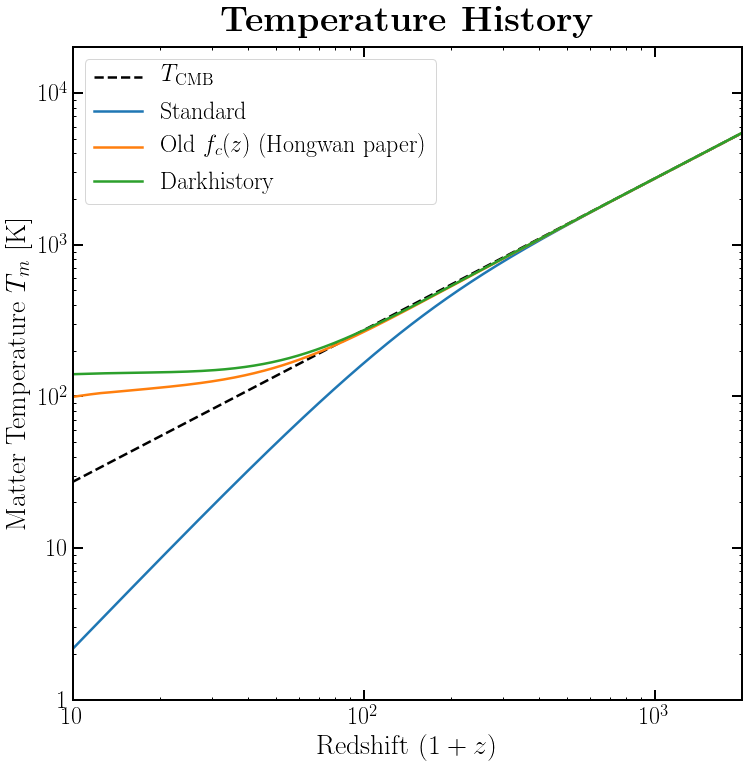

In [86]:
matplotlib.rcParams['figure.figsize'] = [12,12]
plt.figure()

ax = plt.gca()

T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label=r'$T_\mathrm{CMB}$')
T_IGM_std, = plt.plot(std_soln_rs, std_soln_T, label='Standard')
T_IGM_dec, = plt.plot(rs_vec, soln_dec[:,0]/phys.kB, alpha=1.0, label=r'Old $f_c(z)$ (Hongwan paper)')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='Darkhistory')

ax.set_xscale('log')
ax.set_yscale('log')

leg = plt.legend(handles=[T_CMB, T_IGM_std, T_IGM_dec, plt_Tm_std], 
                 #title=r'$m_\chi$\bf{ = '+mass+' '+units+' }',#$(1+z)_\mathrm{td} = 500$',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([10, 2e3, 1, 2e4])

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/T_standard_dec_swave_pwave_constraint.pdf')

# TeVPA Plotting

In [18]:
#Download tau_min and sigma_max

user = 'gridgway'
f_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_electron_extended.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1] 

f_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fFromIonBaseline3keV_photon.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1] 

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def max_xsec_elec_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))
    elif injection_type == 'decay':
        return decay_elec_CMB(mDM*1e-9)

def max_xsec_phot_CMB(mDM, injection_type):
    if injection_type == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))
    elif injection_type == 'decay':
        return decay_phot_CMB(mDM*1e-9)

### Single Temperature History

In [39]:
%autoreload
global user 
user = "gridgway"
end_rs = 5
mDM = 1e8
sigmav = max_xsec_phot_CMB(mDM, 'swave')
tau = max_xsec_phot_CMB(mDM, 'decay')


phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mDM/2]), 
                                      highengphot_tf_interp.eng)
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)

#!!! What about Reionization
std_data = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=True, user="gridgway"
)

backReact_data = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=False, user="gridgway"
)

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


[None, None]

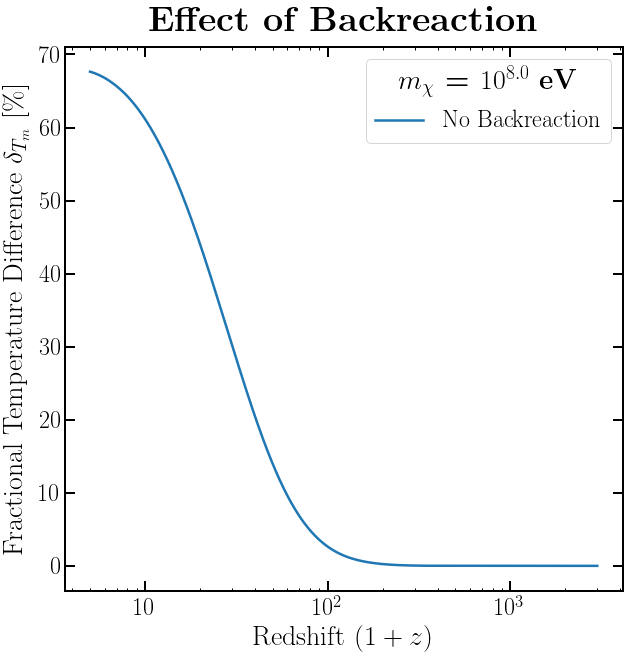

In [50]:
plt.figure()
plt_Tm_diff, = plt.plot(
    std_data[3].rs, np.abs((std_data[1]-backReact_data[1])/std_data[1] * 100), 
    label='No Backreaction'
)

ax = plt.gca()
ax.set_xscale('log')
#ax.set_yscale('log')

plt.title(r'\bf{Effect of Backreaction}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Fractional Temperature Difference $\delta_{T_m}$ [\%]')
leg2 = plt.legend(handles=[plt_Tm_diff],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=1
                 )
plt.setp(leg2.get_title(),fontsize=28)

# Coarsening

In [57]:
%%prun

a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=1, std_soln=std_soln
)
print("coarsen 1")

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 1
 

In [59]:
74.2/24.7

3.0040485829959516

In [62]:
%%prun

a16 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=4, std_soln=std_soln
)
print("coarsen 16")

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 16
 

In [53]:
%autoreload
%time
end_rs = 5
std_soln=True

a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=1, std_soln=std_soln
)
print("coarsen 1")

a2 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=2, std_soln=std_soln
)
print("coarsen 2")

a4 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=4, std_soln=std_soln
)
print("coarsen 4")

a8 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=8, std_soln=std_soln
)
print("coarsen 8")

a16 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
    coarsen_factor=16, std_soln=std_soln
)
print("coarsen 16")

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


coarsen 1
coarsen 2
coarsen 4
coarsen 8
coarsen 16
CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 4.77 µs


[None, None]

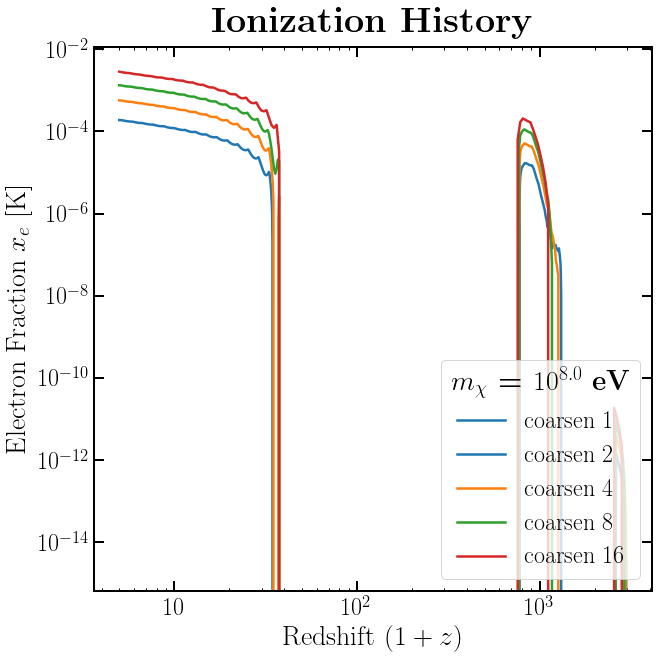

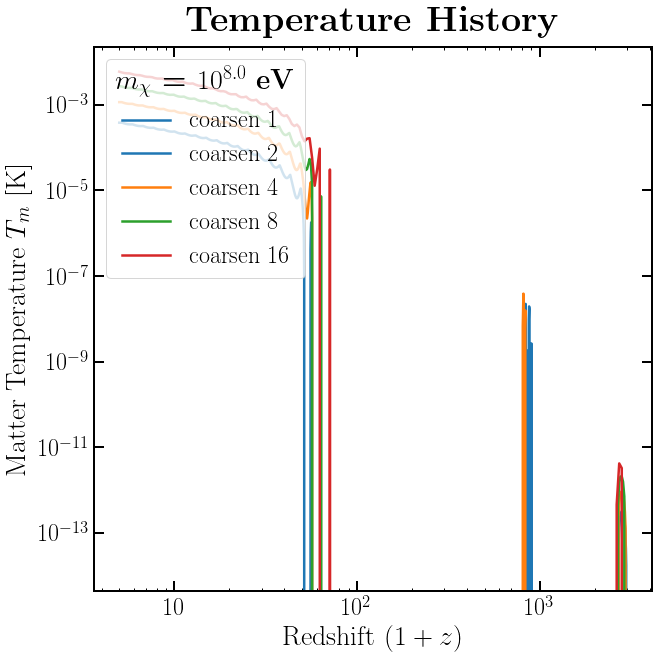

In [56]:
plt.figure()
#plt_1,  = plt.plot(a1[3].rs,  a1[0],  label='coarsen 1')
plt_2,  = plt.plot(a2[3].rs,  (a2[0]-a1[0][::2])/a2[0],  label='coarsen 2')
plt_4,  = plt.plot(a4[3].rs,  (a4[0]-a1[0][::4])/a4[0],  label='coarsen 4')
plt_8,  = plt.plot(a8[3].rs,  (a8[0]-a1[0][::8])/a8[0],  label='coarsen 8')
plt_16, = plt.plot(a16[3].rs, (a16[0]-a1[0][::16])/a16[0], label='coarsen 16')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_1, plt_2, plt_4, plt_8, plt_16],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=4
                )
plt.setp(leg.get_title(),fontsize=28)

plt.figure()
# plt_T1,  = plt.plot(a1[3].rs,  a1[1],  label='coarsen 1')
plt_T2,  = plt.plot(a2[3].rs,  (a2[1]-a1[1][::2])/a2[1],  label='coarsen 2')
plt_T4,  = plt.plot(a4[3].rs,  (a4[1]-a1[1][::4])/a4[1],  label='coarsen 4')
plt_T8,  = plt.plot(a8[3].rs,  (a8[1]-a1[1][::8])/a8[1],  label='coarsen 8')
plt_T16, = plt.plot(a16[3].rs, (a16[1]-a1[1][::16])/a16[1], label='coarsen 16')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_T1, plt_T2, plt_T4, plt_T8, plt_T16],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=2
                 )
plt.setp(leg2.get_title(),fontsize=28)

# Scratch Work

In [408]:
f_decay_phot[9][:25]

array([[ 2.26818545e-02,  1.14536238e-12,  2.73074489e-02,
         2.53877560e-02, -4.48409057e-02],
       [ 4.14194560e-02,  2.17132551e-12,  5.21696956e-02,
         4.93899494e-02,  8.41129582e-02],
       [ 5.19684191e-02,  2.94841465e-12,  6.78175904e-02,
         7.01919493e-02,  1.84912274e-01],
       [ 5.77483890e-02,  3.59475460e-12,  7.74290210e-02,
         8.86007636e-02,  2.62000878e-01],
       [ 6.07820331e-02,  4.17172319e-12,  8.31622224e-02,
         1.05001337e-01,  3.19848384e-01],
       [ 6.22485035e-02,  4.70928100e-12,  8.64417878e-02,
         1.19593015e-01,  3.62513630e-01],
       [ 6.28268328e-02,  5.22041062e-12,  8.81873716e-02,
         1.32508454e-01,  3.93465660e-01],
       [ 6.29040260e-02,  5.70922983e-12,  8.89823186e-02,
         1.43866862e-01,  4.15552251e-01],
       [ 6.26987505e-02,  6.17550251e-12,  8.91915380e-02,
         1.53792911e-01,  4.31045132e-01],
       [ 6.23336867e-02,  6.61713832e-12,  8.90408223e-02,
         1.62419388e-01

In [644]:
direc='/home/gridgway/Desktop/DH_Data/'
#TEMPORARY
hdul = fits.open(
#     '/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/'+
    direc+'tf_z_3.000E+03_nstep_6398_logE_5.764E+00_xe_0.000E+00.fits'
#     'tf_z_3.000E+03_nstep_3_logE_5.764E+00_xe_0.000E+00.fits'
)
data = hdul[1].data

# highengphot_tflist_arr = pickle.load(open(direc+"tfunclist_photspec_60eV_complete.raw", "rb"))

In [645]:
#TEMPORARY
rs_tmp = data.field('redshift')[0,0]
xe_tmp = data.field('hionfraction')[0,0]
E_tmp = data.field('mwimp')[0]

rs_list = data.field('redshift')[0]
highengphots = data.field('photonspectrum')[0]
lowengphots = data.field('lowengphot')[0]
lowengelecs = data.field('lowengelec')[0]

xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

In [646]:
photeng=highengphot_tf_interp.eng

indTmp = spectools.get_indx(photeng, E_tmp)
if photeng[indTmp] > E_tmp:
    indTmp -= 1

In [647]:
#Redshifts to be checked
# entries = np.arange(1)+500#np.array([2, 100, 1000, 2000])
# entries = np.arange(100,len(rs_list),4)
entries = np.array([0])
print('redshifts:', rs_list[entries])
print('tau:', 1/data.field('sigmav')/(phys.rho_crit*phys.omega_DM/E_tmp))

redshifts: [3000.]
tau: [1.00952277e+25]


In [648]:
data.field('cmblosstable')[0][1]

1.6452291540562456e-16

In [658]:
tau=1e25
CMB_engloss_interp.get_val(xe=1, rs=3000)[indTmp]*(
    2* E_tmp/photeng[indTmp] * phys.inj_rate(
        'decay', mDM=E_tmp, tau=tau, rs=3000
    )/E_tmp * .001/phys.hubble(3000) / phys.nB / 3000**3
)

1.6272044219389648e-16

In [652]:
CMB_engloss_interp.get_val(xe=data.field('hionfraction')[0][0], rs=3000)[indTmp]*(
    2*E_tmp/photeng[indTmp] * (
        data.field('annrate')[0][0]
    ) * .001/data.field('hubblerate')[0][0]
)

1.6453078592774784e-16

In [620]:
highengphot_tf_interp.rs

array([   4.        ,    4.56626611,    5.21269655,    5.9506399 ,
          6.79305133,    7.75472002,    8.85252881,   10.10575058,
         11.5363866 ,   13.16955279,   15.03392065,   17.1622206 ,
         19.59181658,   22.36536203,   25.53154867,   29.14596137,
         33.27205392,   37.98226307,   43.35928017,   49.49750292,
         56.50469254,   64.50386567,   73.63545397,   84.05976951,
         95.95981921,  109.54451763,  125.05235464,  142.75558229,
        162.9649944 ,  186.03538282,  212.37176602,  242.43649955,
        276.75739302,  315.93697621,  360.66307695,  411.72089648,
        470.00679424,  536.54402417,  612.50069871,  699.21029593,
        798.19506977,  911.19277434, 1040.18717161, 1187.44285781,
       1355.54502022, 1547.44482208, 1766.51121258, 2016.59007136,
       2302.07172587, 2627.96802697, 3000.00033585])

In [657]:
import darkhistory.history.histools as ht

photeng = highengphot_tf_interp.eng
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

rs_list = highengphot_tf_interp.rs
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

direc='/home/gridgway/Dropbox (MIT)/Photon Deposition/tflists/complete/'
CMB_engloss_arr = pickle.load(open(direc+"CMB_engloss_60eV_complete.raw", "rb"))
CMB_engloss_arr = np.swapaxes(CMB_engloss_arr, 1, 2)
tmp = np.zeros((len(xes),len(rs_list), len(photeng)))

for i, engloss in enumerate(CMB_engloss_arr):
    tmp[i] = np.pad(engloss, ((0,0), (photeng_low.size, 0)), 'constant')
CMB_engloss_arr = tmp.copy()

CMB_engloss_interp    = ht.IonRSInterp(xes, rs_list, CMB_engloss_arr, in_eng = photeng, logInterp=True)

In [660]:
rs_vec

array([2988.02396803, 2976.09574451, 2964.21513859, 2952.38196017,
       2940.59601992, 2928.85712927, 2917.1651004 , 2905.51974624,
       2893.92088045, 2882.36831746, 2870.86187242, 2859.40136123,
       2847.98660053, 2836.61740767, 2825.29360075, 2814.01499859,
       2802.78142073, 2791.59268743, 2780.44861968, 2769.34903916,
       2758.29376829, 2747.28263017, 2736.31544864, 2725.39204821,
       2714.51225411, 2703.67589226, 2692.88278929, 2682.1327725 ,
       2671.42566989, 2660.76131015, 2650.13952265, 2639.56013743,
       2629.02298524, 2618.52789747, 2608.0747062 , 2597.66324418,
       2587.29334483, 2576.96484222, 2566.67757111, 2556.4313669 ,
       2546.22606564, 2536.06150405, 2525.93751951, 2515.85395001,
       2505.81063423, 2495.80741148, 2485.8441217 , 2475.92060548,
       2466.03670403, 2456.19225923, 2446.38711356, 2436.62111014,
       2426.8940927 , 2417.20590562, 2407.55639389, 2397.94540311,
       2388.37277951, 2378.83836992, 2369.3420218 , 2359.88358

In [661]:
rs_vec = np.array([3000*np.exp(-0.001*4*(i+1)) for i in np.arange(6400/4-1)])[:100]
[(rs, CMB_engloss_interp.get_val(xe=xe_std(rs), rs=rs)[indTmp]*(
    2* E_tmp/photeng[indTmp] * phys.inj_rate(
        'decay', mDM=E_tmp, tau=tau, rs=rs
    )/E_tmp * .001/phys.hubble(rs) / phys.nB / rs**3
))
 for rs in rs_vec]

[(2988.0239680319746, 1.617527618473085e-16),
 (2976.095744511182, 1.6079052073380152e-16),
 (2964.2151385857915, 1.59833690434965e-16),
 (2952.3819601658556, 1.5888224266895398e-16),
 (2940.596019920266, 1.5793614928987142e-16),
 (2928.857129273728, 1.5699538228715587e-16),
 (2917.1651004037403, 1.5605991378496486e-16),
 (2905.5197462375927, 1.5512971604157128e-16),
 (2893.920880449369, 1.542047614487528e-16),
 (2882.3683174569696, 1.532850225311924e-16),
 (2870.86187241914, 1.5237047194587517e-16),
 (2859.4013612325143, 1.514610824814931e-16),
 (2847.9866005286685, 1.505568270578472e-16),
 (2836.617407671189, 1.4965767872526043e-16),
 (2825.293600752746, 1.4876361066398214e-16),
 (2814.0149985921885, 1.4787459618360866e-16),
 (2802.7814207316405, 1.469906087224935e-16),
 (2791.5926874336174, 1.4611162184717076e-16),
 (2780.4486196781468, 1.4523760925177495e-16),
 (2769.349039159907, 1.443685447574649e-16),
 (2758.293768285374, 1.4350440231185318e-16),
 (2747.282630169977, 1.426451559

In [510]:
#fs from idl run
entries=np.arange(100)
%autoreload
from darkhistory.low_energy import lowE_deposition as lowE_dep
idl_flist = [
    lowE_dep.compute_fs(
        phot_spec=Spectrum(data.field('energy')[0], phot, rs=rs),
        elec_spec=Spectrum(data.field('eleceng')[0], elec, rs=rs),
        x = np.array([1-xe, 0, 0]),
        dt = .001/hub,
#         highengdep = highdep_interps.get_val(xe, rs)[indTmp],
        highengdep = highdeposited,
        cmbloss = loss,
#         dE_dVdt_inj = phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)*2
        dE_dVdt_inj = 2*E_tmp*rate*phys.nB*rs**3
    )
    for xe, rs, phot, elec, loss, hub, rate, highdeposited in zip(data.field('hionfraction')[0][entries], 
                                   data.field('redshift')[0][entries], 
                                   data.field('lowengphot')[0][entries],
                                   data.field('lowengelec')[0][entries],
                                   data.field('cmblosstable')[0][entries],
                                   data.field('hubblerate')[0][entries],
                                   data.field('annrate')[0][entries],
                                   np.transpose(data.field('highdeposited_grid')[0][:,entries]))]

idl_flist=np.array(idl_flist)
# print(idl_flist)
# print(np.sum(idl_flist))

In [512]:
np.append(np.array([0,1,2]), 3)

array([0, 1, 2, 3])

In [511]:
idl_flist[:10,4]

array([ 0.        , -0.16132469, -0.11942163, -0.07943764, -0.04135207,
       -0.00513233,  0.02925999,  0.06187216,  0.09275713,  0.1219682 ])

In [447]:
data.field('cmblosstable')[0][:10]

array([0.00000000e+00, 1.64522915e-16, 3.26193409e-16, 4.84676583e-16,
       6.39673928e-16, 7.90923587e-16, 9.38198784e-16, 1.08130576e-15,
       1.22008465e-15, 1.35440524e-15])

In [353]:
f_cont(data.field('redshift')[0][3], E_tmp)

0.5366180306446543

In [355]:
data.field('redshift')[0][:6]

array([3000.        , 2997.0014995 , 2994.005996  , 2991.01348651,
       2988.02396803, 2985.03743758])

In [363]:
10**log10eng[9]/E_tmp

1.064700635322978

In [406]:
a1[5]

array([[2.82816790e-02, 9.70003871e-11, 9.70003871e-11, 9.70003871e-01,
        9.70003871e-11],
       [2.82816825e-02, 9.70003990e-11, 9.70003990e-11, 9.70003990e-01,
        9.70003990e-11],
       [2.82816859e-02, 9.70004109e-11, 9.70004109e-11, 9.70004109e-01,
        9.70004109e-11],
       [2.82816894e-02, 9.70004228e-11, 9.70004228e-11, 9.70004228e-01,
        9.70004228e-11],
       [2.82816929e-02, 9.70004347e-11, 9.70004347e-11, 9.70004347e-01,
        9.70004347e-11],
       [2.82816963e-02, 9.70004465e-11, 9.70004465e-11, 9.70004465e-01,
        9.70004465e-11],
       [2.82816998e-02, 9.70004584e-11, 9.70004584e-11, 9.70004584e-01,
        9.70004584e-11],
       [2.82817033e-02, 9.70004703e-11, 9.70004703e-11, 9.70004703e-01,
        9.70004703e-11],
       [2.82817067e-02, 9.70004822e-11, 9.70004822e-11, 9.70004822e-01,
        9.70004822e-11],
       [2.82817102e-02, 9.70004941e-11, 9.70004941e-11, 9.70004941e-01,
        9.70004941e-11],
       [2.82817137e-02, 9.7000

In [456]:
idl_flist[1:,4]

array([0.03925465, 0.07625766, 0.11106585, 0.14374642, 0.17437307,
       0.2030253 , 0.2297876 , 0.25474517, 0.27798723, 0.29960235,
       0.31967737, 0.33830133, 0.35555895, 0.37153254, 0.38630414,
       0.39994859, 0.41254264, 0.42415803, 0.43486091, 0.44471696,
       0.45378893, 0.4621315 , 0.46980154, 0.47684777, 0.48331782,
       0.48925903, 0.49471114, 0.49971406, 0.50430555, 0.50851612,
       0.5123795 , 0.51592373, 0.51917388, 0.52215718, 0.52489596,
       0.52740977, 0.52972094, 0.53184557, 0.53379941, 0.5355997 ,
       0.53725589, 0.53878435, 0.54019619, 0.5415    , 0.54270813,
       0.54382928, 0.54486997, 0.54583964, 0.54674095, 0.54758253,
       0.54837117, 0.54911007, 0.54980461, 0.55046072, 0.55107898,
       0.55166548, 0.55222187, 0.55275006, 0.55325497, 0.55373661,
       0.55419857, 0.55464413, 0.55507293, 0.55548719, 0.55588919,
       0.55627705, 0.55665553, 0.55702426, 0.55738333, 0.55773588,
       0.55808183, 0.5584207 , 0.55875504, 0.55908168, 0.55940

In [394]:
(f_decay_phot[9,:25,:]-idl_flist[3::4,:])/idl_flist[3::4,:]

array([[ 0.41133763,  0.38795376,  0.42841588,  0.35991366, -0.43343006],
       [ 0.10693   ,  0.12362472,  0.11656698,  0.13489494,  0.34151753],
       [ 0.05163356,  0.07304469,  0.05795729,  0.08265591,  0.04526397],
       [ 0.03191557,  0.05425167,  0.03578481,  0.05987886, -0.01960382],
       [ 0.0237626 ,  0.04516256,  0.0258079 ,  0.04709298, -0.05293032],
       [ 0.02061538,  0.0398062 ,  0.02120595,  0.03882517, -0.07554044],
       [ 0.01982446,  0.0360523 ,  0.01937374,  0.03298815, -0.09296127],
       [ 0.02026128,  0.03304818,  0.01897054,  0.02862882, -0.10721858],
       [ 0.02124163,  0.03042493,  0.01937762,  0.02524558, -0.11925922],
       [ 0.02250875,  0.02802602,  0.02015569,  0.02254909, -0.12954025],
       [ 0.02381524,  0.02577838,  0.02112337,  0.02035355, -0.13833151],
       [ 0.02510663,  0.0236542 ,  0.02210827,  0.0185348 , -0.14579145],
       [ 0.02629914,  0.02164173,  0.02305826,  0.01700442, -0.15205238],
       [ 0.02736237,  0.01973697,  0.0

In [358]:
#sum(fs) from 2016 paper
mathematica_flist = [
    np.array(
        [f_H_ion(rs,1),
         f_He_ion(rs,1),
         f_H_exc(rs,1),
         f_heating(rs,1),
         f_cont(rs,1)]
    )
for rs in rs_list[entries]]
mathematica_flist = np.array(mathematica_flist)

# print(mathematica_flist)
# print(np.sum(mathematica_flist))

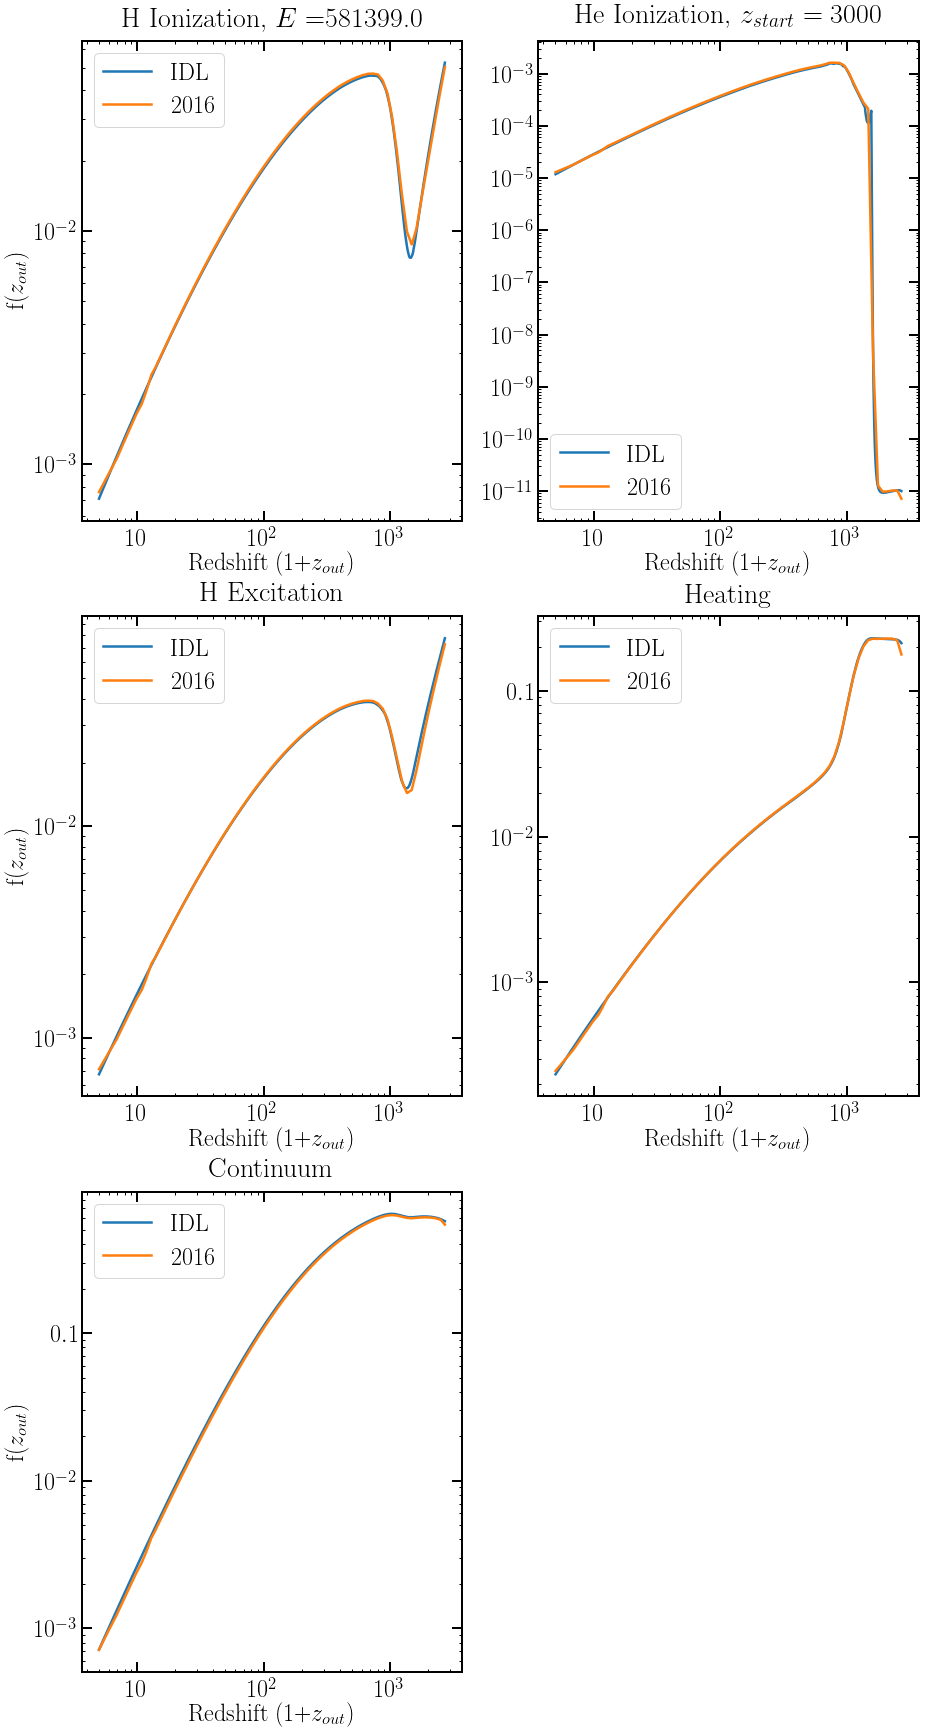

In [360]:
plt.figure(figsize=(15,30))

names = ["H Ionization", "He Ionization", "H Excitation", "Heating", "Continuum"]

for num in np.arange(5):

    ax = plt.subplot(3,2,num+1)
    ax.loglog()
    
    plt.plot(rs_list[entries], idl_flist[:,num])
    plt.plot(rs_list[entries], mathematica_flist[:,num])
    plt.legend(['IDL', '2016'])
    plt.title(names[num])

#     ref_tf_plt, = plt.plot(rs_list[:], f_ref[:,num], 'C1', linewidth=2, label='Reference File')
#     new_tf_plt0, = plt.plot(rs_list[:], f_list[:,num], 'C0--', label='DarkHistory')

#     plt.tick_params(axis='both', which='major', labelsize=20)

    if num == 0:
        plt.title(names[num]+', $E = $'+str(E_tmp), fontsize=28)
    elif num == 1:
        plt.title(names[num]+', $z_{start} = 3000$', fontsize=28)
    else:
        plt.title(names[num], fontsize=28)
    plt.xlabel('Redshift (1+$z_{out}$)',fontsize=24)
    if num%2 == 0:
        plt.ylabel('f($z_{out}$)',fontsize=24)
#         plt.legend(handles=[old_tf_plt, new_tf_plt0], 
#             fontsize=18)
#     plt.axis(
#         [0, 32, 0, 1.1 * max(
#             [max(f_list[:,num]),max(f_ref[:,num])]
#         )]
#     )

extra = 'DHv2'
plt.savefig('/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/f_IDL_vs_mathematica.pdf')
#plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/'+extra+
#            '_log10(E)_'+str(eng_exp)+'.pdf')

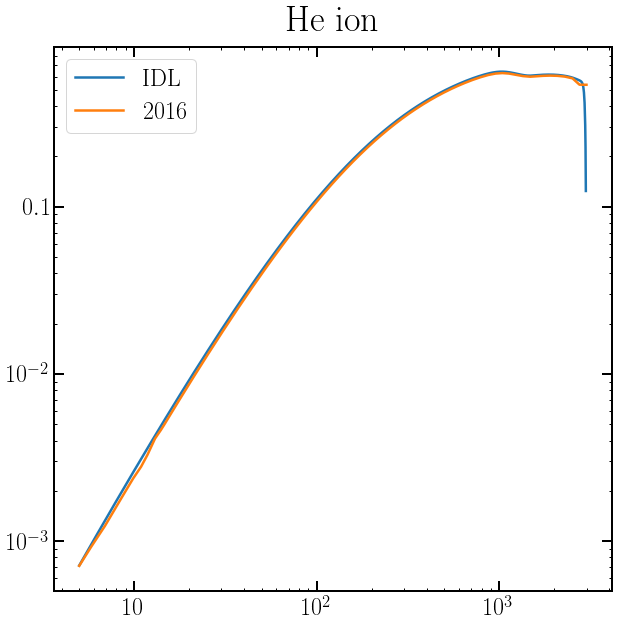

In [251]:
plt.figure()
ax = plt.gca()
ax.loglog()
chan_ind = 4



plt.show()

In [17]:
#TEMPORARY
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

In [577]:
#TEMPORARY
dlnz = 1e-3
nzsteps = 51
initredshift = 3000
finredshift = 4
lnzstep = (np.log(initredshift) - np.log(finredshift))/(nzsteps-1)
redshiftgrid = np.exp(np.log(4) + lnzstep*np.arange(nzsteps))

In [103]:
#TEMPORARY
mmin = 5e3
mmax = 1e13
nmwimpsteps = 40
nengsteps = 51
lowinjE = 60
mwimp = mmin*np.exp((np.arange(nmwimpsteps))*np.log(mmax/mmin)/nmwimpsteps)
mwimpmax = mwimp[-1]

injE = lowinjE*np.exp((np.arange(nengsteps)*np.log(mwimpmax/lowinjE)/nengsteps))
injE = np.insert(injE[1:] ,0, 61)

In [106]:
injE[-1]/1e12

3.5644894081221503

In [148]:
rsTmp=10
np.sum([
    f_H_ion(rsTmp,1),
    f_He_ion(rsTmp,1),
    f_H_exc(rsTmp,1),
    f_heating(rsTmp,1),
    f_cont(rsTmp,1)
])

0.0062153351388832857

In [60]:
utils.compare_arr([a1[5][200:,4],mathematica_flist[:-1,4]])

[[ 0.53355914  0.58994547]
 [ 0.53367782  0.59010106]
 [ 0.53382712  0.59025669]
 ..., 
 [ 0.60252961  0.62900322]
 [ 0.60164816  0.62896266]
 [ 0.60078687  0.6289221 ]]


0

In [107]:
a1[5][:10,:]

array([[  1.09664764e-05,   8.89265204e-14,   1.00472218e-05,
          4.33990927e-03,  -1.60791408e-01],
       [  8.58562724e-03,   4.76180593e-13,   1.00709253e-02,
          1.16798129e-02,  -1.18540728e-01],
       [  1.60695878e-02,   8.25184832e-13,   1.91118802e-02,
          1.86437487e-02,  -7.83675677e-02],
       [  2.25942519e-02,   1.14137896e-12,   2.72238626e-02,
          2.52763229e-02,  -4.02438885e-02],
       [  2.82760566e-02,   1.42946548e-12,   3.44914373e-02,
          3.16152146e-02,  -4.13107804e-03],
       [  3.32180329e-02,   1.69350343e-12,   4.09929377e-02,
          3.76921547e-02,   3.00181808e-02],
       [  3.75112271e-02,   1.93699090e-12,   4.68006767e-02,
          4.35337835e-02,   6.22582506e-02],
       [  4.12359923e-02,   2.16293742e-12,   5.19812004e-02,
          4.91624012e-02,   9.26490716e-02],
       [  4.44631583e-02,   2.37392751e-12,   5.65955717e-02,
          5.45966216e-02,   1.21254869e-01],
       [  4.72550878e-02,   2.5721763

In [109]:
a1[5][:10,:]

array([[  1.09884342e-05,   8.89265204e-14,   1.00672300e-05,
          4.34651792e-03,  -1.61212659e-01],
       [  8.58567146e-03,   4.76180593e-13,   1.00709656e-02,
          1.16931075e-02,  -1.19379470e-01],
       [  1.60696545e-02,   8.25184832e-13,   1.91119408e-02,
          1.86637877e-02,  -7.96191072e-02],
       [  2.25943412e-02,   1.14137896e-12,   2.72239437e-02,
          2.53031462e-02,  -4.19026759e-02],
       [  2.82761687e-02,   1.42946548e-12,   3.44915391e-02,
          3.16488441e-02,  -6.19078619e-03],
       [  3.32181678e-02,   1.69350343e-12,   4.09930601e-02,
          3.77325950e-02,   2.75645806e-02],
       [  3.75113847e-02,   1.93699090e-12,   4.68008195e-02,
          4.35810228e-02,   5.94184126e-02],
       [  4.12361726e-02,   2.16293742e-12,   5.19813637e-02,
          4.92164117e-02,   8.94312015e-02],
       [  4.44633612e-02,   2.37392751e-12,   5.65957552e-02,
          5.46573607e-02,   1.17667652e-01],
       [  4.72553130e-02,   2.5721763

In [102]:
utils.compare_arr([a1[3].rs[200:-1], idl_flist[:-1,3]/mathematica_flist[:-1,3]])#/a1[5][200:,3]])

[[  2.45373729e+03   1.00491774e+00]
 [  2.45128478e+03   1.00470796e+00]
 [  2.44883472e+03   1.00449395e+00]
 [  2.44638711e+03   1.00427554e+00]
 [  2.44394195e+03   1.00405351e+00]
 [  2.44149923e+03   1.00382763e+00]
 [  2.43905895e+03   1.00359795e+00]
 [  2.43662111e+03   1.00336498e+00]
 [  2.43418571e+03   1.00312801e+00]
 [  2.43175274e+03   1.00288777e+00]
 [  2.42932220e+03   1.00264441e+00]
 [  2.42689409e+03   1.00239766e+00]
 [  2.42446841e+03   1.00214798e+00]
 [  2.42204516e+03   1.00189620e+00]
 [  2.41962432e+03   1.00164171e+00]
 [  2.41720591e+03   1.00138479e+00]
 [  2.41478991e+03   1.00112507e+00]
 [  2.41237632e+03   1.00086245e+00]
 [  2.40996515e+03   1.00059771e+00]
 [  2.40755639e+03   1.00033037e+00]
 [  2.40515004e+03   1.00006100e+00]
 [  2.40274609e+03   9.99788618e-01]
 [  2.40034455e+03   9.99512958e-01]
 [  2.39794540e+03   9.99235609e-01]
 [  2.39554866e+03   9.98956498e-01]
 [  2.39315430e+03   9.98674891e-01]
 [  2.39076235e+03   9.98392124e-01]
 

0

In [51]:
mathematica_flist[:,0]

array([ 0.03747068,  0.03735744,  0.03724455,  0.03713199,  0.03701978,
        0.0369079 ,  0.03679636,  0.03668516,  0.03657429,  0.03646376,
        0.03635357,  0.0362437 ,  0.03613417,  0.03602497,  0.0359161 ,
        0.03580756,  0.03569935,  0.03559146,  0.0354839 ,  0.03537666,
        0.03526975,  0.03516317,  0.0350569 ,  0.03495096,  0.03484533,
        0.03474003,  0.03463504,  0.03453037,  0.03442602,  0.03432198,
        0.03421825,  0.03411484,  0.03401175,  0.03390896,  0.03380648,
        0.03370432,  0.03360246,  0.03350091,  0.03339967,  0.03329873,
        0.0331981 ,  0.03309777,  0.03299775,  0.03289803,  0.03279861,
        0.03269949,  0.03260067,  0.03250215,  0.03240392,  0.03230599,
        0.03220836,  0.03211103,  0.03201398,  0.03191724,  0.03182078,
        0.03172461,  0.03162874,  0.03153316,  0.03143786,  0.03134285,
        0.03124813,  0.0311537 ,  0.03105955,  0.030963  ,  0.03086585,
        0.030769  ,  0.03067246,  0.03057622,  0.03048029,  0.03

In [48]:
mathematica_flist = [
    np.array(
        [f_H_ion(rs,1),
         f_He_ion(rs,1),
         f_H_exc(rs,1),
         f_heating(rs,1),
         f_cont(rs,1)]
    )
for rs in a1[3].rs[200:]]
mathematica_flist = np.array(mathematica_flist)

In [552]:
entries = np.arange(1000)

In [553]:
from darkhistory.low_energy import lowE_deposition as lowE_dep
idl_flist = [
    lowE_dep.compute_fs(
        phot_spec=Spectrum(data.field('energy')[0], phot, rs=rs),
        elec_spec=Spectrum(data.field('eleceng')[0], elec, rs=rs),
        x = np.array([1-xe, 0, 0]),
        dt = .001/hub,
#         highengdep = highdep_interps.get_val(xe, rs)[indTmp],
        highengdep = highdeposited,
        cmbloss = loss,
        dE_dVdt_inj = phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)*2
#         dE_dVdt_inj = 2*mwimp*rate*phys.nB*rs**3
    )
    for xe, rs, phot, elec, loss, hub, rate, highdeposited in zip(data.field('hionfraction')[0][entries], 
                                   data.field('redshift')[0][entries], 
                                   data.field('lowengphot')[0][entries],
                                   data.field('lowengelec')[0][entries],
                                   data.field('cmblosstable')[0][entries],
                                   data.field('hubblerate')[0][entries],
                                   data.field('annrate')[0][entries],
                                   np.transpose(data.field('highdeposited_grid')[0][:,entries]))
]

idl_flist=np.array(idl_flist)

In [115]:
%autoreload
coarsen_factor = 4

tau=1e25
a2 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
#     ics_thomson_ref_tf_2, ics_rel_ref_tf_2, engloss_ref_tf_2,
    coarsen_factor=coarsen_factor, std_soln=std_soln,
    struct_boost=None, verbose=True
)

completed rs:  3000.0
completed rs:  2988.02396803
completed rs:  2976.09574451
completed rs:  2964.21513859
completed rs:  2952.38196017
completed rs:  2940.59601992
completed rs:  2928.85712927
completed rs:  2917.1651004
completed rs:  2905.51974624
completed rs:  2893.92088045
completed rs:  2882.36831746
completed rs:  2870.86187242
completed rs:  2859.40136123
completed rs:  2847.98660053
completed rs:  2836.61740767
completed rs:  2825.29360075
completed rs:  2814.01499859
completed rs:  2802.78142073


In [149]:
tmp=np.array([a1[2][4*int(i)]+a1[2][4*int(i)+1]+a1[2][4*int(i)+2]+a1[2][4*int(i)+3] for i in np.arange(np.floor(len(a1[2].rs)/4))])
[np.dot(CMB_engloss_interp.get_val(xe_std(rs), rs), spec.N) for rs, spec in zip(a2[2].rs,tmp)]

[1.8581853149709092e-15,
 5.1142157121356749e-15,
 8.3186973486294936e-15,
 1.0935927693632034e-14,
 1.2654367507711179e-14,
 1.3532449284965521e-14,
 1.3913776754628122e-14,
 1.4219668956688391e-14]

In [152]:
tmp=np.array([a1[2][i] for i in np.arange(len(a1[2].rs))])
[np.dot(CMB_engloss_interp.get_val(xe_std(rs), rs), spec.N) for rs, spec in zip(a1[2].rs,tmp)][1:]

[3.6140627841305213e-16,
 5.5526860782629664e-16,
 7.55772219750139e-16,
 9.6101837210186297e-16,
 1.1689047087337312e-15,
 1.3772265112426783e-15,
 1.5836562836111958e-15,
 1.7858912472530326e-15,
 1.9816610340334365e-15,
 2.1688458278598382e-15,
 2.3455180486124669e-15,
 2.5100343701939607e-15,
 2.6610692384021723e-15,
 2.7976887956154e-15,
 2.9193494762554332e-15,
 3.0259418611313351e-15,
 3.1177541845057974e-15,
 3.1954605625942128e-15,
 3.2600719638146093e-15,
 3.3128690346285364e-15,
 3.3553455483328454e-15,
 3.3891352132912797e-15,
 3.4159467041206299e-15,
 3.4375132602678699e-15,
 3.4555500537684567e-15,
 3.4717217218723464e-15,
 3.4876272382961377e-15,
 3.5047932277206567e-15,
 3.52466984787827e-15,
 3.5486231741021965e-15,
 3.5779185147483382e-15,
 3.6136865536100085e-15,
 3.6568690006728313e-15,
 3.7081458662439051e-15]

In [120]:
print(a2[5])

[[  3.49400631e-02   2.01893645e-12   5.02115142e-02   3.80054540e-02
   -1.68168302e+00]
 [  5.01814757e-02   3.96467402e-12   8.43941537e-02   6.90830419e-02
   -1.40664619e+00]
 [  5.30215161e-02   6.41896889e-12   9.67872964e-02   1.04441395e-01
   -9.87948066e-01]
 [  5.30188725e-02   9.69446886e-12   1.00186669e-01   1.45133650e-01
   -5.12576857e-01]
 [  5.24761464e-02   1.36262924e-11   1.00478568e-01   1.88873491e-01
   -1.18795681e-01]
 [  5.18313141e-02   1.77013284e-11   9.97687869e-02   2.31636714e-01
    9.48629568e-02]
 [  5.11667175e-02   2.13957478e-11   9.87760642e-02   2.70172828e-01
    1.16817713e-01]
 [  5.05039185e-02   2.46879983e-11   9.77736497e-02   3.06317455e-01
   -1.89747855e-02]]


In [164]:
mathematica_flist[:,0].shape

(6398,)

In [165]:
utils.compare_arr([a1[5][:,0], mathematica_flist[1:-1,0]])

[[  5.07123809e-05   5.20693418e-02]
 [  1.51440708e-02   5.20693418e-02]
 [  2.65137513e-02   5.20693418e-02]
 ..., 
 [  1.42653037e-03   7.61147155e-04]
 [  1.42487506e-03   7.60362753e-04]
 [  1.42321478e-03   7.59579159e-04]]


0

In [158]:
#sum(fs) from 2016 paper
mathematica_flist = [
    np.array(
        [f_H_ion(rs,1),
         f_He_ion(rs,1),
         f_H_exc(rs,1),
         f_heating(rs,1),
         f_cont(rs,1)]
    )
for rs in a1[2].rs]
mathematica_flist = np.array(mathematica_flist)

# Checking Transfer Functions and f$_c$(z)

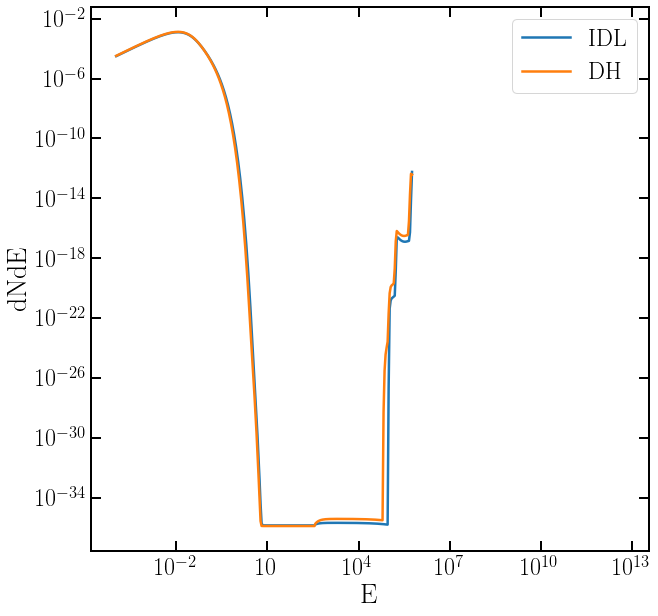

In [315]:
plt.plot()
ax=plt.gca()
ax.loglog()

plt.plot(photeng, data.field('photonspectrum')[0][2])
plt.plot(photeng, a1[2][1].dNdE)
plt.legend(['IDL', 'DH'])
plt.xlabel('E')
plt.ylabel('dNdE')

# plt.savefig('/Users/GregoryRidgway/Desktop/highengphot.png')
plt.show()

!!!! Include deposition from electron cooling processes

In [21]:
photeng = data.field('energy')[0]
eleceng = data.field('eleceng')[0]

In [384]:
# sum(fs) from idl run

tmp = [
    phys.nB*rs**3 * (phys.hubble(rs)/.001 *(
        Spectrum(data.field('energy')[0], phot, rs=rs).toteng(bound_type='eng', bound_arr=[1e-12, 10.2])
#         Spectrum(data.field('eleceng')[0], elec, rs=rs).toteng(bound_type='eng', bound_arr=[10.2, 13.6])
    ) - loss)/phys.inj_rate('decay', rs, mDM=E_tmp, tau=tau)/2
    for rs, phot, elec, loss, hub in zip(rs_list[entries], 
                                    lowengphots[entries],
                                    lowengelecs[entries],
                                    data.field('cmblosstable')[0][entries],
                                    data.field('hubblerate')[0][entries])
]
print(tmp)

[array([ 0.43022173])]


In [ ]:
tau=1e23
a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf_2, ics_rel_ref_tf_2, engloss_ref_tf_2,
    coarsen_factor=coarsen_factor, std_soln=std_soln,
    struct_boost=None
)
print('Done 1')
# tau = 1e24

# a2 = main.evolve(
#     elec_spec_init, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
#     Tm_init=phys.TCMB(elec_spec_init.rs),
#     coarsen_factor=coarsen_factor, std_soln=std_soln
# )
# print('Done 2')
# tau=1e25

# a3 = main.evolve(
#     elec_spec_init, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
#     Tm_init=phys.TCMB(elec_spec_init.rs),
#     coarsen_factor=coarsen_factor, std_soln=std_soln
# )
# print('Done 3')

# b = main.evolve(
#     phot_spec_init*0, phot_spec_init,
#     rate_func_N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, 
#     coarsen_factor=1, std_soln=False
# )

In [668]:
# plt.figure()
# plt_0, = plt.plot(soln[0,:], soln[2,:], label='None')
# plt_3, = plt.plot(a3[3].rs, a3[0], label='1e25')
# plt_2, = plt.plot(a2[3].rs, a2[0], label='1e24')
# plt_1, = plt.plot(a1[3].rs, a1[0], label='1e23')

# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.title(r'\bf{Ionization History}')
# plt.xlabel(r'Redshift $(1+z)$')
# plt.ylabel(r'Electron Fraction $x_e$ [K]')
# leg = plt.legend(handles=[plt_3, plt_2, plt_1],
#                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
#                  loc=2
#                 )
# plt.setp(leg.get_title(),fontsize=28)
# plt.axis([5, 2e3, 1e-4, 1])
# #plt.savefig('/home/gridgway/Desktop/xe_decay_comparison.png')

# plt.figure()
# plt_T0, = plt.plot(soln[0,:], soln[1,:]/phys.kB, label='None')
# plt_T3, = plt.plot(a3[3].rs, a3[1]/phys.kB, label='1e25')
# plt_T2, = plt.plot(a2[3].rs, a2[1]/phys.kB, label='1e24')
# plt_T1, = plt.plot(a1[3].rs, a1[1]/phys.kB, label='1e23')

# # plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
# ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.title(r'\bf{Temperature History}')
# plt.xlabel(r'Redshift $(1+z)$')
# plt.ylabel(r'Matter Temperature $T_m$ [K]')
# leg2 = plt.legend(handles=[plt_T3, plt_T2, plt_T1],
#                   title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
#                   loc=4
#                  )
# plt.setp(leg2.get_title(),fontsize=28)
# plt.axis([5, 2e3, 1, 1e4])
# #plt.savefig('/home/gridgway/Desktop/Tm_decay_comparison.png')

[20000.0, 1000000000000.0, 6e+22, 1e+31]

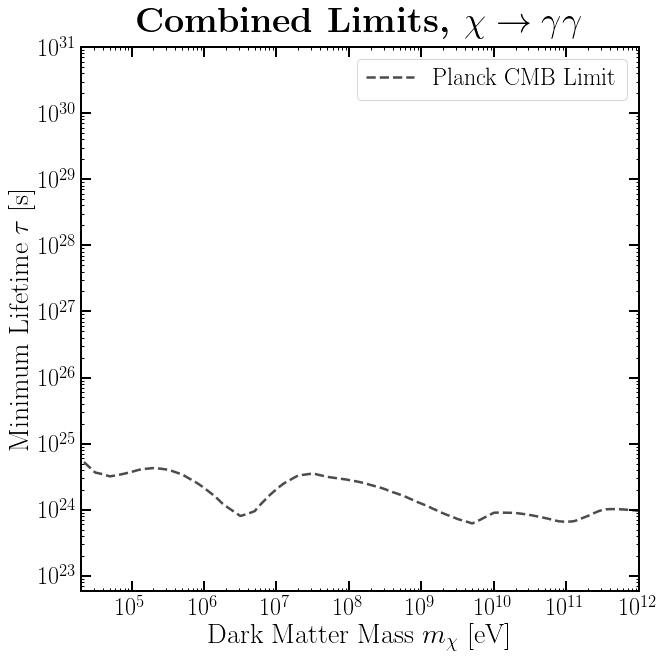

In [21]:
log10mDM_fine = np.log10(10**np.arange(4, 12.5, 0.05) + 2*phys.me*0)
log10tau_fine = np.arange(22, 30, 0.05)
lim_CMB, = plt.plot(
    10**log10mDM_fine, max_xsec_phot_CMB(10**log10mDM_fine, 'decay'), 
    color='black', alpha=0.7, linestyle='dashed'
)

lim_CMB.set_label(r'Planck CMB Limit')

leg = plt.legend(loc=1)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Combined Limits}, $\chi \to \gamma \gamma$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.ylabel(r'Minimum Lifetime $\tau$ [s]')
plt.axis([2e4, 1e12, 6e22, 1e31])

In [154]:
# p-wave structure formation
NFW_subs_data = []
with open('/home/gridgway/Dropbox (MIT)/21cm_pwave/math/data/rho_eff_NFW_subs_pwave.txt') as f:
    for line in f:
        inner_list = [float(num.strip()) for num in line.split(' ') if num]
        NFW_subs_data.append(inner_list)
        
NFW_subs_data = np.array(NFW_subs_data)
NFW_subs_data[:,2] *= .839418
NFW_subs_data[:,0] += 1
sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
NFW_subs_data[:,1] = phys.rho_DM * NFW_subs_data[:,0]**4 * 10**-9 * sigma_1D_B/phys.c

struct_boost_raw = (NFW_subs_data[:,2]/NFW_subs_data[:,1])**2

log10_struct_boost = interp1d(NFW_subs_data[:,0], np.log10(struct_boost_raw))

def struct_boost(rs):
    if rs < NFW_subs_data[-1,0]:
        return 10**log10_struct_boost(rs)
    else:
        return 1.

- RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded

- why are there fewer energy bins in CMB_engloss_arr than the tflists?

In [52]:
CMB_engloss_arr.shape

(11, 321, 51)

In [151]:
# Spectra of CMB as a function of rs
eng = a[3].eng
CMB_spectra = Spectra([
    Spectrum(
        eng, 
        5e-9*phys.CMB_spec(eng, phys.TCMB(rs)) * 
        CMB_engloss_interp(min(a[0][i], .999), rs) * phys.nB*rs**3 * highengphot_tf_interp.dlnz/phys.hubble(rs) / np.sum(
            np.insert(np.diff(eng), 0, eng[1]-eng[0]) * eng * phys.CMB_spec(eng, phys.TCMB(rs))
        ), 
        rs=rs
    )
    for i, rs in enumerate(a[3].rs)
])
CMB_spectra.switch_spec_type()

In [136]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])
CMB_engloss_interp = interp2d(xes, highengphot_tf_interp.rs, np.transpose(np.sum(CMB_engloss_arr, 1)))

[0.0001, 10000.0, 1e-44, 5000]

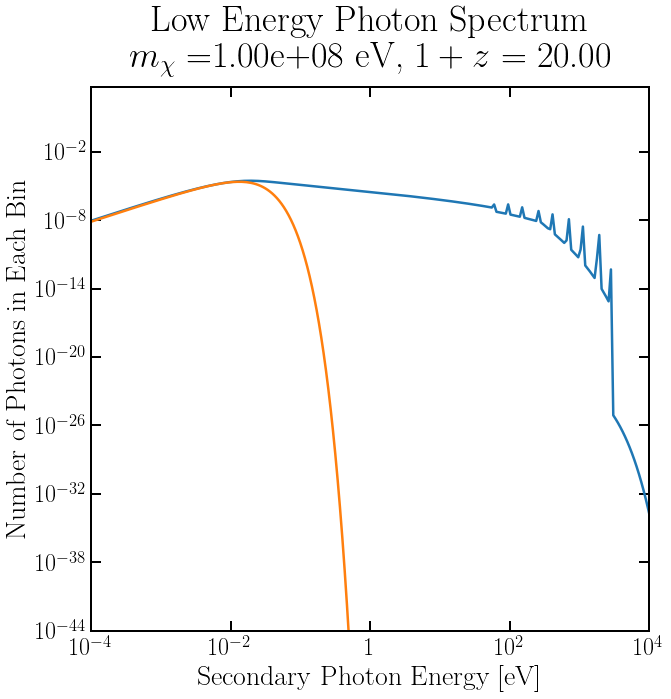

In [152]:
plt.figure()

rs_plot = 20.0

ax = plt.gca()
tf_plot, = a[3].plot(ax, ind=rs_plot, fac=1, indtype='rs')
CMB_plot, = CMB_spectra.plot(ax, ind=rs_plot, indtype='rs')
# tf_plot, = lowengphot_spectra.plot(ax, ind=20)


ax.set_xscale('log')
ax.set_yscale('log')

plt.title('Low Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mDM)
          +r' eV, $1+z$ = '+'{0:.2f}'.format(rs_plot)
         )

#ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))


plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 1e4, 1e-44, 5000])

#plt.savefig('/home/gridgway/Desktop/CMB_subtract.png')

In [230]:
temp2 = np.array([
    np.append(rs,compute_fs(
        Spectrum(temp[3].eng, elec_spec, rs=rs, spec_type='N'), 
        Spectrum(temp[3].eng, phot_spec, rs=rs, spec_type='N'),
        np.array([1-xe, 0, 0]), 
        rate_func_decay_eng(rs), 
        highengphot_tf_interp.dlnz/phys.hubble(rs)
    ))
    for (rs, xe, phot_spec, elec_spec) in zip(temp[3].rs[1:], temp[0][1:], temp[3], temp[4])
])
print(temp2[-20:])

AttributeError: 'numpy.ndarray' object has no attribute 'rs'

# NEED TO CHECK

In [393]:
import darkhistory.low_energy.lowE_deposition as lowE_dep
%autoreload

time=-2
tau=1e23
rs_tmp = a1[3][time].rs
print(sum(lowE_dep.compute_fs(
    a1[4][time], 
    a1[3][time], 
    np.array([1-xe_std(rs_tmp),0,0]), 
    rate_func_eng(rs_tmp), 
    .002/phys.hubble(rs_tmp), 
    0
))*rate_func_eng(rs_tmp)*.002/phys.hubble(rs_tmp)/phys.nB/rs_tmp**3)
print(a1[4][time].toteng()+a1[3][time].toteng())

0.0054045385439492315
0.005405394701886692


-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?

-Why don't we go above 5 TeV?

TODO:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation


- Structure Formation
    - swave
    - on/off switch
    - optimistic/conservative
    - (just a change to the annihilation rate)
    
- minimum lifetime (do this first, structure independent)/maximum cross-section
    - residual plot of with back-reaction vs. not back-react (temperature), contour plots
    - for each mass pick the minimum tau or maximum cross-section and compare the std_switch on or off
    
- New 21cm sensitivity
    - Hongwan's plots, but now with DarkHistory